# CAE-LSTM Hybrid Model (Training)

**Authors:** KHOO Jing Heng, Zayne SIEW

**Version:** 1.0 (05/04/2025)

### About this notebook

This notebook implements a CAE-LSTM model for training on the ECoG data.

### Requirements

- Python 3
- Matplotlib
- Numpy
- Scipy
- Torch

## 0. Imports and Torch-CUDA Config

In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from constants import (
    SUBJECT_ID,
    CHANNELS_NUM,
    ECOG_TRAIN_FILEPATH,
    ECOG_VAL_FILEPATH,
    FLEXION_TRAIN_FILEPATH,
    FLEXION_VAL_FILEPATH,
    WAVELET_NUM,
)
from data import EcogDataset, plot_ecog_data
from eval import cosine_correlation_metric, pearson_correlation_metric, test_model
from model import EncoderDecoder

In [2]:
# For windows/linux will try CUDA first, then CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Set default device for following code, so we don't need to specify device every time
torch.set_default_device(DEVICE)

cuda


## 1. Data Loading and Visualisation

In [3]:
# Define directory where data is stored
DATA_DIR = "../data"

finger_flex_cropped: np.ndarray = np.load(f'{DATA_DIR}/{FLEXION_TRAIN_FILEPATH}')
X_spectrogram_cropped: np.ndarray = np.load(f'{DATA_DIR}/{ECOG_TRAIN_FILEPATH}')

finger_flex_cropped_val: np.ndarray = np.load(f'{DATA_DIR}/{FLEXION_VAL_FILEPATH}')
X_spectrogram_cropped_val: np.ndarray = np.load(f'{DATA_DIR}/{ECOG_VAL_FILEPATH}')

In [4]:
train_dataset = EcogDataset(X_spectrogram_cropped, finger_flex_cropped)
print(X_spectrogram_cropped.shape, finger_flex_cropped.shape)
print(len(train_dataset))

val_dataset = EcogDataset(X_spectrogram_cropped_val, finger_flex_cropped_val)
print(X_spectrogram_cropped_val.shape, finger_flex_cropped_val.shape)
print(len(val_dataset))

(64, 40, 39980) (5, 39980)
39724
(64, 40, 19980) (5, 19980)
19724


In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, generator=torch.Generator(device='cuda'))
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, generator=torch.Generator(device='cuda'))

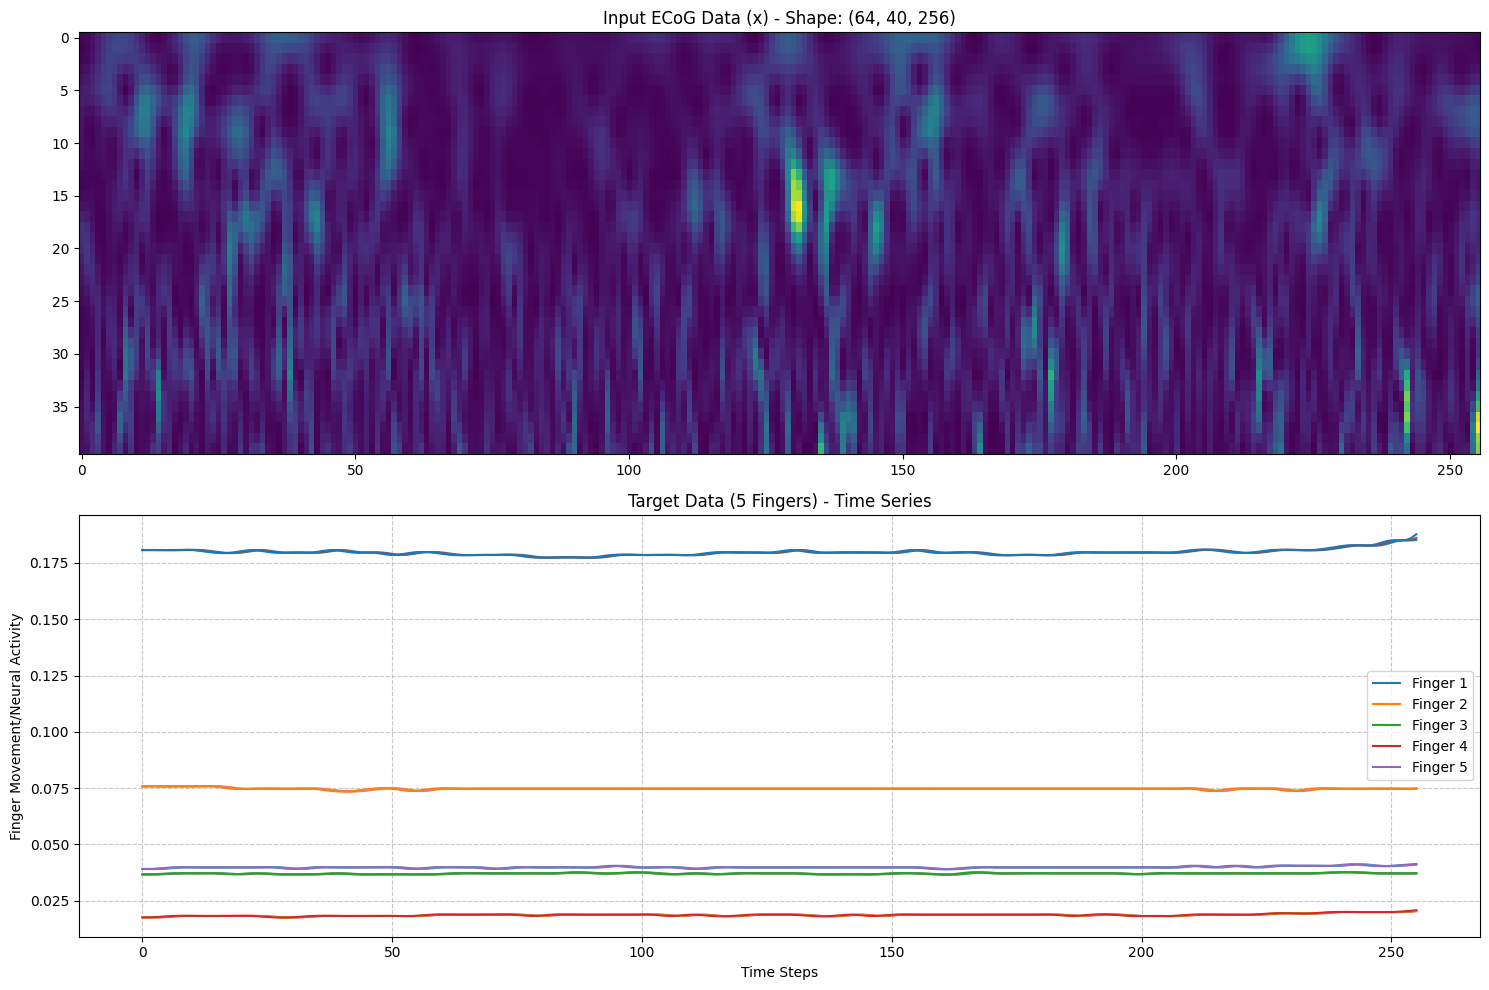

Input (x) Data Statistics:
Shape: (64, 40, 256)
Mean: 32.44941711425781
Std: 101.38238525390625
Min: -79.2274169921875
Max: 2238.67041015625

Target (y) Data Statistics:
Shape: (5, 256)
Mean: 0.07001503556966782
Std: 0.05776946619153023
Min: 0.017546391114592552
Max: 0.18522779643535614


In [6]:
# Call the visualization function
plot_ecog_data(train_dataset)

## 2. Model Training

This section trains a new `EncoderDecoder` model.

In [7]:
def train(
    model: EncoderDecoder,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 100,
    lr: float = 1e-3,
    device: torch.device = DEVICE,
    alpha: float = 0.5,
    weight_decay: float = 1e-4,
) -> EncoderDecoder:
    """Trains an instance of an `EncoderDecoder` model.

    This function also outputs evaluation metrics on the validation set while training.

    Parameters:
        model (EncoderDecoder):
            The `EncoderDecoder` model instance to train.
        train_lodaer (DataLoader):
            Dataloader of the training dataset.
        val_loader (DataLoader):
            Dataloader of the validation dataset.
        num_epochs (int, default=100):
            Number of epochs to train the model on.
        lr (float, default=1e-3):
            Learning rate of the `AdamW` optimiser.
        device (torch.device, default=DEVICE):
            Desired torch device to use for computation.
        alpha (float, default=0.5):
            Weightage in loss function between MSE loss and cosine similarity.
        weight_decay (float, default=1e-4):
            Weight decay for the `AdamW` optimiser.

    Returns:
        EncoderDecoder:
            The trained model.
    """

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    train_corrs, val_corrs = [], []
    pearson_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_corr = 0.0

        for batch in train_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            pred = model(x)

            mse_loss = F.mse_loss(pred, y)
            corr = cosine_correlation_metric(pred, y)
            final_loss = alpha*mse_loss + alpha*(1. - corr)

            final_loss.backward()
            optimizer.step()

            train_loss += final_loss.item()
            train_corr += corr.item()

        train_loss /= len(train_loader)
        train_corr /= len(train_loader)
        train_losses.append(train_loss)
        train_corrs.append(train_corr)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Corr: {train_corr:.4f}")

        model.eval()
        val_loss = 0.0
        val_corr = 0.0
        pearson_loss_sum = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)

                pred = model(x)

                mse_loss = F.mse_loss(pred, y)
                corr = cosine_correlation_metric(pred, y)
                final_loss = alpha*mse_loss + alpha*(1. - corr)

                pearson_loss_metric = pearson_correlation_metric(pred, y)

                val_loss += final_loss.item()
                val_corr += corr.item()
                pearson_loss_sum += pearson_loss_metric.item()

        val_loss /= len(val_loader)
        val_corr /= len(val_loader)
        pearson_loss_sum /= len(val_loader)

        val_losses.append(val_loss)
        val_corrs.append(val_corr)
        pearson_losses.append(pearson_loss_sum)

        print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}, Val Corr: {val_corr:.4f}, Pearson Corr: {pearson_loss_sum:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    # Plot correlation metrics
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_corrs, label='Train Corr', marker='o')
    plt.plot(range(1, num_epochs + 1), val_corrs, label='Val Corr', marker='o')
    plt.plot(range(1, num_epochs + 1), pearson_losses, label='Pearson Corr', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Training, Validation, Pearson Correlation")

    plt.tight_layout()
    plt.show()

    return model

In [8]:
# model = EncoderDecoder(input_channels=CHANNELS_NUM * WAVELET_NUM, output_channels=5)
# model = train(model, train_loader, val_loader, num_epochs=50)

### 2.1 GridSearchCV Hyperparameter Tuning

We tune on the learning rate, alpha, and weight decay.


Testing hyperparams: {'lr': 0.005, 'alpha': 0.3, 'weight_decay': 0.0001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.0774, Train Corr: 0.9099
Epoch 1/50 - Val Loss: 0.0272, Val Corr: 0.9415, Pearson Corr: 0.7035
Epoch 2/50 - Train Loss: 0.0076, Train Corr: 0.9841
Epoch 2/50 - Val Loss: 0.0313, Val Corr: 0.9344, Pearson Corr: 0.7087
Epoch 3/50 - Train Loss: 0.0037, Train Corr: 0.9917
Epoch 3/50 - Val Loss: 0.0344, Val Corr: 0.9322, Pearson Corr: 0.7027
Epoch 4/50 - Train Loss: 0.0024, Train Corr: 0.9946
Epoch 4/50 - Val Loss: 0.0350, Val Corr: 0.9303, Pearson Corr: 0.7051
Epoch 5/50 - Train Loss: 0.0018, Train Corr: 0.9960
Epoch 5/50 - Val Loss: 0.0273, Val Corr: 0.9421, Pearson Corr: 0.7148
Epoch 6/50 - Train Loss: 0.0016, Train Corr: 0.9964
Epoch 6/50 - Val Loss: 0.0337, Val Corr: 0.9309, Pearson Corr: 0.7011
Epoch 7/50 - Train Loss: 0.0012, Train Corr: 0.9973
Epoch 7/50 - Val Loss: 0.0320, Val Corr: 0.9326, Pearson Corr: 0.7041
Epoch 8/50 - Train Loss: 0.0078, Train Corr: 0.9845
Ep

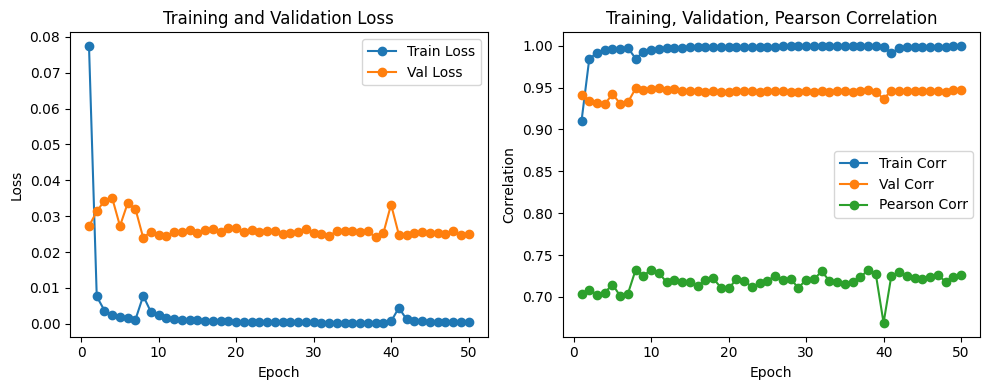

Final Pearson score: 0.7047

Best hyperparameters: {'lr': 0.005, 'alpha': 0.3, 'weight_decay': 0.0001, 'num_epochs': 50}
Best Pearson score: 0.7047


In [9]:
param_grid = {
    'lr': [5e-3],
    'alpha': [0.3],
    'weight_decay': [1e-4],
    'num_epochs': [50]
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

best_score = -float('inf')
best_params = None
best_model = None

for combo in param_combinations:
    params = dict(zip(param_names, combo))
    print(f"\nTesting hyperparams: {params}")

    model = EncoderDecoder(input_channels=CHANNELS_NUM * WAVELET_NUM, output_channels=5)

    trained_model = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=params['num_epochs'],
        lr=params['lr'],
        alpha=params['alpha'],
        weight_decay=params['weight_decay'],
        device='cuda'
    )

    # Evaluate final Pearson correlation from the model
    actuals, predictions = test_model(model, val_loader, device=DEVICE)
    final_pearson = pearson_correlation_metric(torch.tensor(predictions), torch.tensor(actuals)).item()
    print(f"Final Pearson score: {final_pearson:.4f}")

    if final_pearson > best_score:
        best_score = final_pearson
        best_params = params
        best_model = trained_model

print(f"\nBest hyperparameters: {best_params}")
print(f"Best Pearson score: {best_score:.4f}")

### 2.2 Best Model

In [10]:
actuals, predictions = test_model(best_model, val_loader, device=DEVICE)
print(actuals.shape, predictions.shape)

(19724, 5, 256) (19724, 5, 256)


In [ ]:
# Print pearon correlation (SotA model 0.67)
final_pearson = pearson_correlation_metric(torch.tensor(predictions), torch.tensor(actuals)).item()
print("Final Pearson Correlation: ", final_pearson)
torch.save(best_model.state_dict(), f"../{SUBJECT_ID}.pth")

Final Pearson Correlation:  0.7047158479690552
